

# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [0]:
# Importamos las librerías necesarias, tanto las de procesado como las de ploteado
import matplotlib.pyplot as plt 
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)  # Revisar qué implica esto
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
sns.set(color_codes=True)   # Revisar si hay que modificar

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.cross_validation import train_test_split
# from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
# from sklearn.grid_search import GridSearchCV, ParameterGrid
# from sklearn.cluster import KMeans



## Lectura de datos

In [0]:
# diabetes = spark.read.csv(DATA_PATH+'diabetic_data.csv', sep=',', header=True, inferSchema=True).toPandas()
# admission_source = spark.read.csv(DATA_PATH+'admission_source_id.csv', sep=',', header=True, inferSchema=True).toPandas()
# admission_type = spark.read.csv(DATA_PATH+'admission_type_id.csv', sep=',', header=True, inferSchema=True).toPandas()
# discharge_disposition = spark.read.csv(DATA_PATH+'discharge_disposition_id.csv', sep=',', header=True, inferSchema=True).toPandas()

## Cambiamos la importación a local ## 

diabetes = pd.read_csv('diabetic_data.csv') 
admission_source = pd.read_csv('admission_source_id.csv')
admission_type = pd.read_csv('admission_type_id.csv')
discharge_disposition = pd.read_csv('discharge_disposition_id.csv')



### Comprobar correcta lectura de los datos

In [0]:
diabetes.head() # Correctamente leídos

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [0]:
admission_source.head() # Correctamente leídos. Parece común con el primer DF la columna 'admission_source_id'

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [0]:
admission_type.head() # Correctamente leídos. Parece común con el primer DF la columna 'admission_type_id'

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [0]:
discharge_disposition.head() # Correctamente leídos. Parece común con el primer DF la columna 'discharge_disposition_id'

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution




### Juntar todos los datos en el mismo DataFrame

Cambiamos el nombre de las etiquetas de columnas que podrían llevar a confusión en cada dataframe a unir y comprobamos

In [0]:
admission_type.rename(columns={'description':'admission_type_desc'}, inplace=True)
admission_source.rename(columns={'description':'admission_source_desc'}, inplace=True)
discharge_disposition.rename(columns={'description':'discharge_disposition_desc'}, inplace=True)
discharge_disposition.head()

,discharge_disposition_id,discharge_disposition_desc
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


Unimos en un mismo DF tanto diabetes como admission_source considerando las columnas comunes por cada archivo
En esta parte, añadimos la descripción del admission_type a cada registro

In [0]:
diabetes_adm = pd.merge(diabetes, admission_source, on=['admission_source_id'], how='left', )
diabetes_adm

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,NO,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency Room
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,Steady,No,No,No,No,No,No,Yes,>30,Clinic Referral
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,Steady,No,No,No,No,No,Ch,Yes,NO,Clinic Referral
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,Yes,>30,Emergency Room
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,Steady,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,Steady,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital


Unimos el resultado anterior con admission_type

In [0]:
diabetes_adm_type = pd.merge(diabetes_adm, admission_type, on=['admission_type_id'], how='left', )
diabetes_adm_type

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_desc,admission_type_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,NO,Physician Referral,None
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,Yes,NO,Emergency Room,Emergency
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,No,No,No,No,No,Yes,>30,Clinic Referral,Urgent
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,No,No,No,No,Ch,Yes,NO,Clinic Referral,Elective
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,Yes,>30,Emergency Room,Emergency
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Urgent
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Elective


Unimos el resultado anterior con discharge_disposition para una única tabla final con todo: diabetes_data

In [0]:
diabetes_data = pd.merge(diabetes_adm_type, discharge_disposition, on=['discharge_disposition_id'], how='left', )
diabetes_data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,No,No,No,No,Yes,>30,Clinic Referral,Urgent,Discharged to home
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,No,No,No,Ch,Yes,NO,Clinic Referral,Elective,Discharged to home
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,Yes,>30,Emergency Room,Emergency,Discharged to home
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Urgent,Discharged to home
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Elective,Discharged/transferred to SNF


In [0]:
diabetes_data_bckp = diabetes_data.copy() # Guardamos copia de seguridad del merge final

Asignamos encounter_id como índice de la diabetes_data

In [0]:
diabetes_data.index=diabetes_data['encounter_id']

In [0]:
diabetes_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
149190,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
64410,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
500364,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
16680,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home




### Estudiar las dimensiones del dataset

Vemos los cambios en la tabla

In [0]:
dim_origin = diabetes.shape  # Con esto vemos las dimensiones de la tabla original, almacenamos en variable
dim_origin

(101766, 50)

In [0]:
dim_final = diabetes_data.shape # Con esto vemos las dimensiones de la tabla final ampliada, almacenamos en variable
dim_final

(101766, 53)

Almacenamos en variables las filas y columnas de la tabla diabetes original y la ampliada, por si fuera necesario realizar comprobaciones más adelante.

In [0]:
total_in_files = dim_origin[0]
total_fin_files = dim_final[0]
total_in_cols = dim_origin[1]
total_fin_cols = dim_final[1]

#### Vemos que tiene el mismo número de registros, pero 3 columnas más, coherentes con los merge de los otros 3 archivos, que aportaban una columna cada uno.

Comprobamos la estructura, typos y registros inicialmente no nulos de cada columna

In [0]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

También para la tabla final. Tampoco hay nulos en principio y ocupa 3 megas más en memoria. Las 3 nuevas columnas son object (40-37)

In [0]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 53 columns):
encounter_id                  101766 non-null int64
patient_nbr                   101766 non-null int64
race                          101766 non-null object
gender                        101766 non-null object
age                           101766 non-null object
weight                        101766 non-null object
admission_type_id             101766 non-null int64
discharge_disposition_id      101766 non-null int64
admission_source_id           101766 non-null int64
time_in_hospital              101766 non-null int64
payer_code                    101766 non-null object
medical_specialty             101766 non-null object
num_lab_procedures            101766 non-null int64
num_procedures                101766 non-null int64
num_medications               101766 non-null int64
number_outpatient             101766 non-null int64
number_emergency              101766 non-n



## Data Wrangling



### Cambiar los nombres de las columnas para que cumplan buenas prácticas

Vemos los nombres de las columnas para comprobar naming best practices y los sustituimos en caso necesario

In [0]:
diabetes_col_labels = list(diabetes_data.columns)  # Casteamos como lista para poder modificar los strings
diabetes_col_labels = [x.replace('-','_').strip().lower() for x in diabetes_col_labels] # Reemplazamos caracteres
diabetes_data.columns = diabetes_col_labels 
diabetes_data.columns  # Está cambiado correctamente

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'admission_source_desc', 'admission_type_desc',
       'discharge_disposition_desc'],



### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

Revisamos los tipos de dato de cada columna para ver su adecuación. A priori, hay varios _id que deberían ser string y no numéricos. Todas las labels que comienzan con num ya son correctamente tipo int. Age y otras variables que instintivamente parecerían numéricas, están bien asignadas al tratarse de un rango, que se trata como str

In [0]:
diabetes_data.dtypes

encounter_id                  int64 
patient_nbr                   int64 
race                          object
gender                        object
age                           object
weight                        object
admission_type_id             int64 
discharge_disposition_id      int64 
admission_source_id           int64 
time_in_hospital              int64 
payer_code                    object
medical_specialty             object
num_lab_procedures            int64 
num_procedures                int64 
num_medications               int64 
number_outpatient             int64 
number_emergency              int64 
number_inpatient              int64 
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses              int64 
max_glu_serum                 object
a1cresult                     object
metformin                     object
repaglinide                   object
nateglinide                   object
c

Obtenemos una serie que asignamos a diabetes_col_err con los labels de las columnas terminadas en _id

In [0]:
diabetes_col_err = diabetes_data.filter(regex=('_id')).dtypes
diabetes_col_err # Vemos que todos los _id tienen formato int. Siendo Ids deberían ser str

encounter_id                int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
dtype: object

Asignamos los índices de la serie a una lista para poder iterar

In [0]:
diabetes_id_idx = list(diabetes_col_err.index)
diabetes_id_idx

['encounter_id',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id']

Añadimos la columna patient_nbr, ya que parece más una id de tipo indexado que un número

In [0]:
diabetes_id_idx.append('patient_nbr')
diabetes_id_idx

['encounter_id',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'patient_nbr']

Cambiamos todos los objetos _id a str

In [0]:
diabetes_data[diabetes_id_idx] = diabetes_data[diabetes_id_idx].applymap(str)
diabetes_data[diabetes_id_idx].dtypes

encounter_id                object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
patient_nbr                 object
dtype: object



### Estudiar si hay registros repetidos

Eliminamos registros duplicados para la clave patient_nbr y nos quedamos sólo con la primera ocurrencia

In [0]:
diabetes_data.drop_duplicates(keep='first')
diabetes_data.shape[0] == dim_origin[0]

True

Vemos que las filas son iguales, por lo que no hay registros duplicados (entendidos como filas completas duplicadas)



### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

Obtenemos una lista con los nombres de las variables con valor único (todos los registros iguales), para luego eliminarlas

In [0]:
diabetes_val_un = diabetes_data.nunique() # Comprobamos las variables con un único valor (todos los registros iguales) ya que no aportan

Una forma de obtenerlo : diabetes_val_un[diabetes_val_un == 1].index pero utilizamos para tener directamente una lista:

In [0]:
vbles_ex=[x for x in diabetes_data.nunique().index if diabetes_data.nunique()[x]==1]
vbles_ex

['examide', 'citoglipton']

Pasamos la lista anterior a la función drop para eliminar las columnas cuyos datos no aportan al modelo

In [0]:
diabetes_data = diabetes_data.drop(vbles_ex, axis=1)   # Eliminamos las columnas de la lista y sobreescribimos DF
diabetes_data.shape  # Comprobamos que cambia el número de columnas

(101766, 51)



### Estudiar los nulos en el dataset

Con .isnull() sobre los valores únicos del DF podemos ver para cada columna si tiene nulos o no. En este caso, trataremos los ? como valores nulos si son más del 50% de los valores de toda la columna.

Comprobamos las columnas con valores de tipo 'object' y las sacamos a una lista para iterar los ? y asignar Null. Con esta lista, tenemos el argumento para la función .applymap() a aplicar sobre el dataframe

In [0]:
cols_type_obj = [x for x in diabetes_data.dtypes.index if diabetes_data.dtypes[x]== 'object']
cols_type_obj

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'a1cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide_metformin',
 'glipizide_metformin',
 'glimepiride_pioglitazone',
 'metformin_rosiglitazone',
 'metformin_pioglitazone',
 'change',
 'diabetesmed',
 'readmitted',
 'admission_source_desc',
 'admission_type_desc',
 'discharge_disposition_desc']

In [0]:
diabetes_type_obj = diabetes_data[cols_type_obj].replace('?',np.nan).copy()

Otras formas:

prueba = diabetes_data[cols_type_obj].applymap(lambda x: x.replace('?', np.nan))

prueba = diabetes_data[cols_type_obj].applymap(lambda x: x if x != '?' else np.nan)

In [0]:
diabetes_type_obj.head()  # Vemos que ha asignado correctamente valores NaN (nulos)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,NaN,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
149190,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,NaN,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
64410,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,NaN,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
500364,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,NaN,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
16680,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,NaN,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home


Calculamos los porcentajes de nulos para cada columna

In [0]:
dbt_percent_nulls = diabetes_type_obj.isnull().sum() / total_fin_files * 100
dbt_percent_nulls # La variable weight no parece aportar información, cuando el 96% de sus registros son nulos.

encounter_id                  0.000000 
patient_nbr                   0.000000 
race                          2.233555 
gender                        0.000000 
age                           0.000000 
weight                        96.858479
admission_type_id             0.000000 
discharge_disposition_id      0.000000 
admission_source_id           0.000000 
payer_code                    39.557416
medical_specialty             49.082208
diag_1                        0.020636 
diag_2                        0.351787 
diag_3                        1.398306 
max_glu_serum                 0.000000 
a1cresult                     0.000000 
metformin                     0.000000 
repaglinide                   0.000000 
nateglinide                   0.000000 
chlorpropamide                0.000000 
glimepiride                   0.000000 
acetohexamide                 0.000000 
glipizide                     0.000000 
glyburide                     0.000000 
tolbutamide                   0.000000 


Tratamos de obtener una lista de columnas a eliminar para todas aquellas cuyo porcentaje de nulos sobre el total de registros sea superior a 70%

In [0]:
col_null = [x for x in dbt_percent_nulls.index if dbt_percent_nulls[x] > 70]
col_null  # Almacenamos en la lista col_null las variables a eliminar por tener demasiados valores nulos.

['weight']

In [0]:
diabetes_data = diabetes_data.drop(col_null, axis=1) # Eliminamos del archivo de datos la/s columna/s con valores >70% null
diabetes_data

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_source_desc,admission_type_desc,discharge_disposition_desc
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,?,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
149190,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
64410,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
500364,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
16680,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
35754,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,?,...,No,No,No,No,No,Yes,>30,Clinic Referral,Urgent,Discharged to home
55842,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,?,...,No,No,No,No,Ch,Yes,NO,Clinic Referral,Elective,Discharged to home
63768,63768,114882984,Caucasian,Male,[70-80),1,1,7,5,?,...,No,No,No,No,No,Yes,>30,Emergency Room,Emergency,Discharged to home
12522,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,?,...,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Urgent,Discharged to home


Comprobamos las dimensiones de la tabla tras haber eliminado dos tablas que con valores únicos y una tabla con elevado porcentaje de null

In [0]:
diabetes_data.shape

(101766, 50)



### Estudiar los outliers

Empezamos con las numéricas

In [0]:
df_numerical = diabetes_data.select_dtypes(include = ['float64', 'int64']) # Con esto se excluye el objeto object
df_numerical.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
encounter_id,,,,,,,,
2278392,1,41,0,1,0,0,0,1
149190,3,59,0,18,0,0,0,9
64410,2,11,5,13,2,0,1,6
500364,2,44,1,16,0,0,0,7
16680,1,51,0,8,0,0,0,5


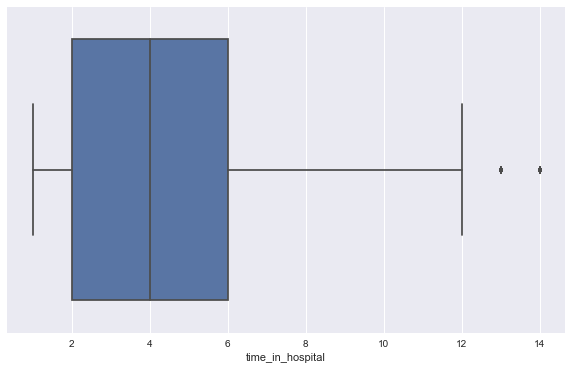

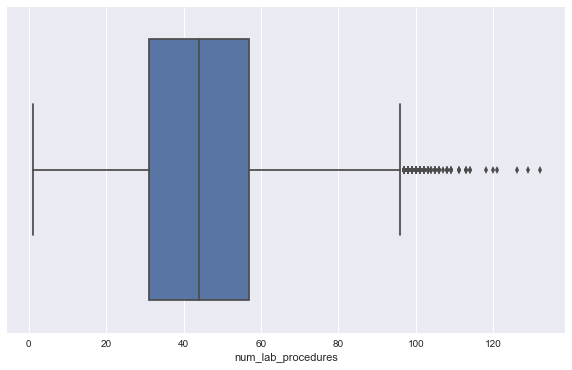

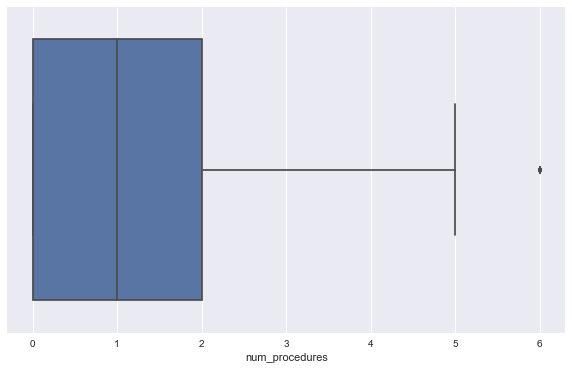

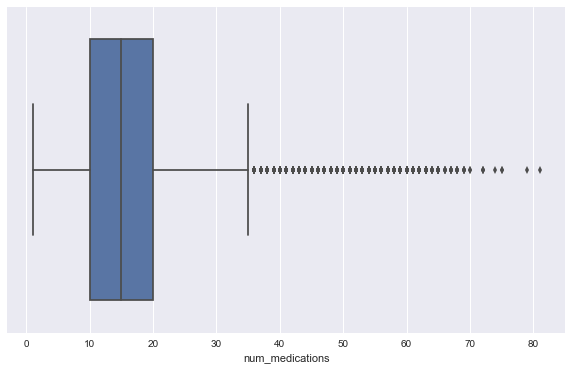

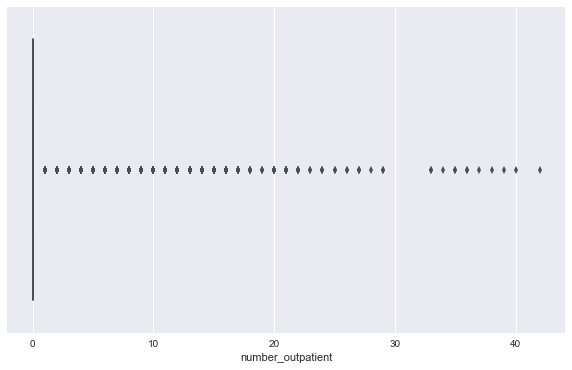

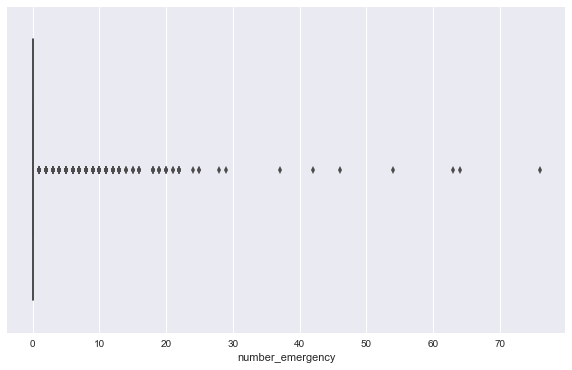

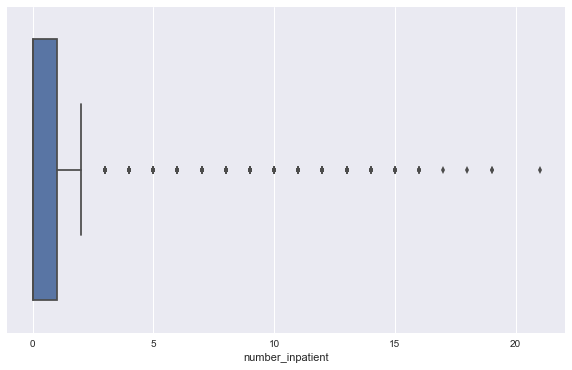

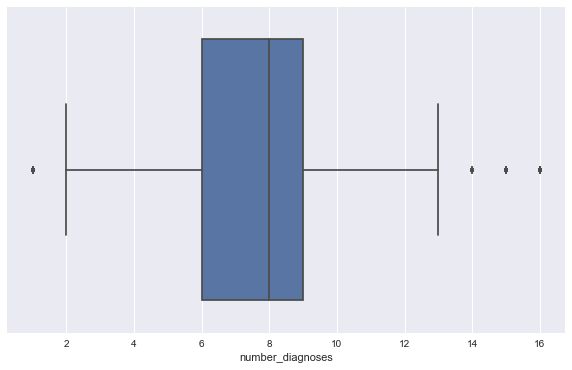

In [0]:
for i in df_numerical:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=i, data=diabetes_data)
# df_numerical.hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10); # Crea un histograma para cada variable numérica

#### Aparentemente hay varias tablas con posibles outliers
* De las 8 columnas numéricas que tenemos, vemos que para tres de ellas (number_outpatient, number_emergency y number_inpatient) hay enorme concentración en 0 y consecuentemente muchos outliers para resto de valores, por lo que probamos a crear una nueva columna, consult_number para estudiar su comportamiento

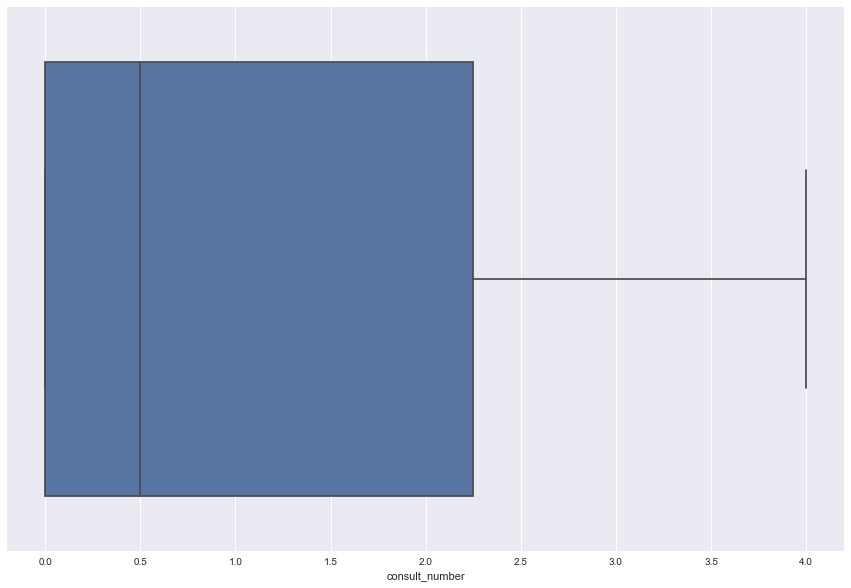

In [0]:
diabetes_data['consult_number'] = diabetes_data['number_outpatient'] + diabetes['number_emergency'] + diabetes['number_inpatient']
plt.figure(figsize=(15,10))  # Creamos el contenedor
sns.boxplot(x=diabetes_data['consult_number'], data=diabetes_data)

* Visto que los valores siguen tremendamente concentrados entre 0 y 1 con un número elevado de outliers, entendemos que ni la nueva variable ni las anteriores aportan valor al estudio y, por tanto, las eliminamos manualmente, al haber detectado esta situación en análisis visual.

In [0]:
diabetes_data = diabetes_data.drop(['number_outpatient','number_emergency','number_inpatient','consult_number'], axis=1)
df_numerical = diabetes_data.select_dtypes(include = ['float64', 'int64']) # Actualizamos listado de variables numéricas

In [0]:
diabetes_data.shape  # Comprobamos con shape que se ha realizado sólo eliminación de 4 columnas.

(101766, 47)

* Para el resto de variables, estudiamos los valores con Tukey. Definimos la función

In [0]:
def tukey_outliers(df,column,extreme=False):  # Definimos una función
    q1, q3 = np.percentile(df[column],[25,75])  # Asigna a q1 el percentil 25 y a q3 el percentil 75
    iqr = q3 - q1  # Rango intercuartílico (ancho de la caja en gráfico de velas)
    constant = 1.5 if not extreme else 3
    return df[~((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))] 

La vamos aplicando incrementalmente para cada variable.

In [0]:
tukey_temp1 = tukey_outliers(df_numerical, 'time_in_hospital', extreme=False)
tukey_temp2 = tukey_outliers(tukey_temp1, 'num_lab_procedures', extreme=False)
tukey_temp3 = tukey_outliers(tukey_temp2, 'num_procedures', extreme=False)
tukey_temp4 = tukey_outliers(tukey_temp3, 'num_medications', extreme=True) # Aquí eliminamos sólo los valores extremos
tukey_final = tukey_outliers(tukey_temp4, 'number_diagnoses', extreme=False)
print('Se han eliminado {} registros con outliers'.format(total_in_files - tukey_final.shape[0])) # Registros eliminados

Se han eliminado 7548 registros con outliers


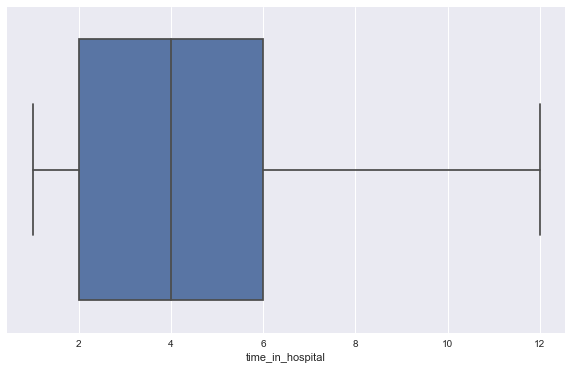

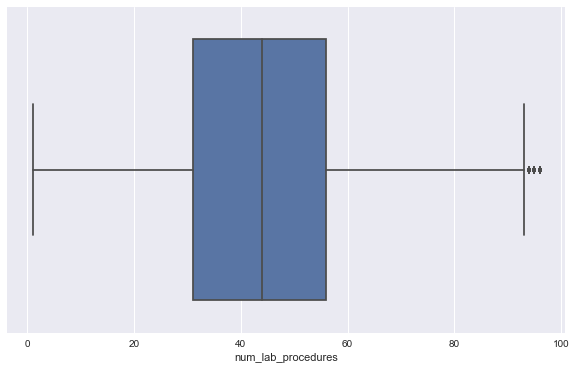

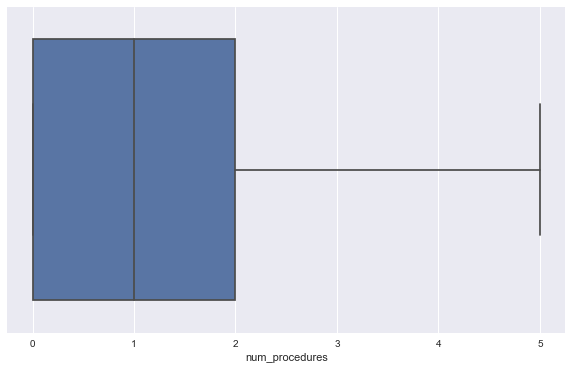

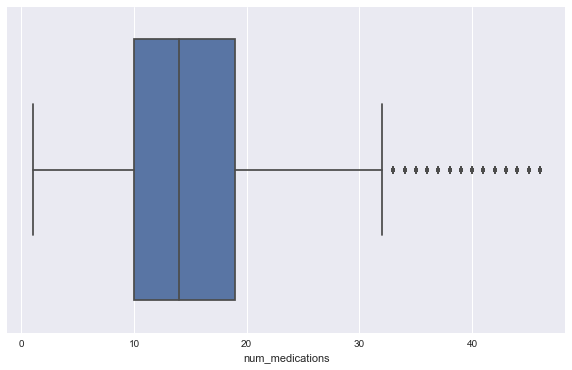

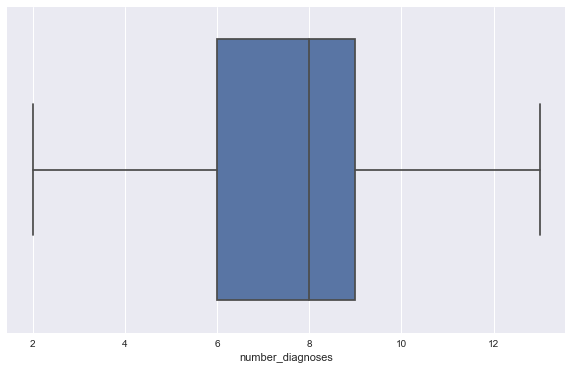

In [0]:
for i in df_numerical:              # Ploteamos todas las numéricas
    plt.figure(figsize=(10,6))
    sns.boxplot(x=i, data=tukey_final)

Ahora tenemos una nueva tabla, denominada tukey_final resultado de la limpieza de variables int y outliers del dataframe original. La cruzamos con diabetes_data en una nueva tabla depurada: diabetes_model

In [0]:
diabetes_model = diabetes_data.loc[diabetes_data.index.isin(tukey_final.index)]
diabetes_model.shape

(94218, 47)

## Para variables no numéricas, vemos su estructura:

In [0]:
df_object = [x for x in diabetes_data.dtypes.index if diabetes_data.dtypes[x]=='object']
df_object

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'a1cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide_metformin',
 'glipizide_metformin',
 'glimepiride_pioglitazone',
 'metformin_rosiglitazone',
 'metformin_pioglitazone',
 'change',
 'diabetesmed',
 'readmitted',
 'admission_source_desc',
 'admission_type_desc',
 'discharge_disposition_desc']

In [0]:
object_grouped = diabetes_model.filter(df_object, axis=1)
object_grouped.shape

(94218, 42)



### Crear variables dummy en caso que sea conveniente

Creamos dummy para variable categórica gender (que conocemos que contiene rangos de edades). Elegimos de entre todas las categóricas no ordinales gender a modo de ejemplo, ya que por el momento no hemos decidido aún sobre qué variables modelar.

In [0]:
dummy = pd.get_dummies(diabetes_data['gender'])
dummy

,Female,Male,Unknown/Invalid
encounter_id,,,
2278392,1,0,0
149190,1,0,0
64410,1,0,0
500364,0,1,0
16680,0,1,0
35754,0,1,0
55842,0,1,0
63768,0,1,0
12522,1,0,0




### Estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

Hecho previamente



### Antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

Hecho anteriormente.



# Exploratory Data Analysis



### Crear la matriz de correlación

In [0]:
correlation_matrix = abs(diabetes_model.corr())
correlation_matrix

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
time_in_hospital,1.000000,0.293732,0.167320,0.433965,0.210582
num_lab_procedures,0.293732,1.000000,0.012925,0.223781,0.143521
num_procedures,0.167320,0.012925,1.000000,0.307299,0.042688
num_medications,0.433965,0.223781,0.307299,1.000000,0.261099
number_diagnoses,0.210582,0.143521,0.042688,0.261099,1.000000


In [0]:
correlation_matrix >=0.25


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
time_in_hospital,True,True,False,True,False
num_lab_procedures,True,True,False,False,False
num_procedures,False,False,True,True,False
num_medications,True,False,True,True,True
number_diagnoses,False,False,False,True,True


Calculamos las de valor absoluto de correlación superior a 0.25

In [0]:
sol = (correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
       
sol[sol > 0.25]

time_in_hospital  num_medications       0.433965
num_procedures    num_medications       0.307299
time_in_hospital  num_lab_procedures    0.293732
num_medications   number_diagnoses      0.261099
dtype: float64

Las de mayor correlación son las mostradas, especialmente entre time_in hospital y num_medications

No se muestran valores de correlación inferiores a -0.5 (inversas) ni superiores a 0.5 (directas)



### Pintar la matriz de correlación

Mostramos mapa de calor

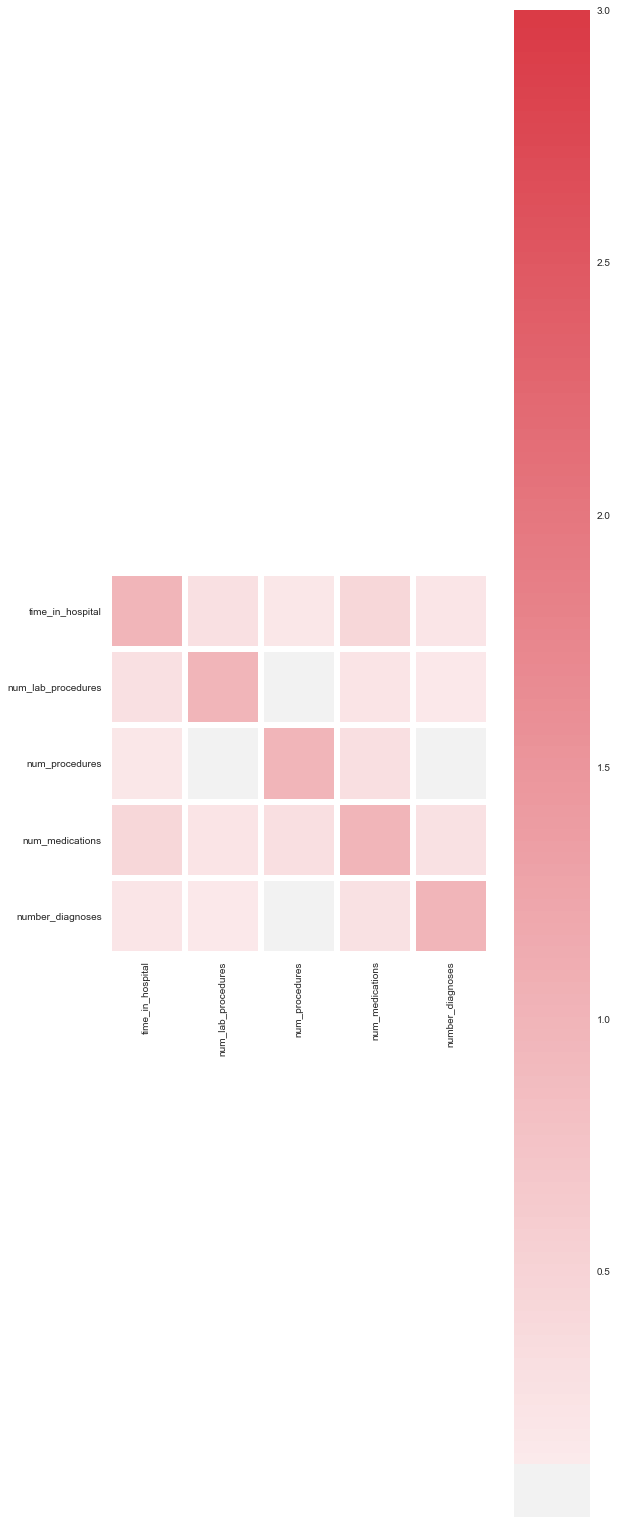

In [0]:
f, ax = plt.subplots(figsize = (9, 7))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(correlation_matrix, cmap = cmap, vmax = 3, center = 0, square = True , linewidths = 5, cbar_kws={'shrink':5})
#los más rojos tienen algo de correlación, los azules oscuros indican corr inversa. Corr 0 son los beiges



### Determinar qué par de variables están correlacionadas
#### Conclusión: no hay correlación entre las variables numéricas.